In [13]:
def exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

def T2_fun(x, a, b, c, d, phi):
    return a * np.exp(-2*b * x)*np.sin(w*x + phi) + c

In [9]:
import qiskit
from qiskit.ignis.characterization.coherence import T1Fitter
from qiskit.ignis.characterization.coherence import t1_circuits
from qiskit.providers.aer import*


def T1Benchmark(noise_model):
    num_of_gates = (np.linspace(10, 1000, 50)).astype(int)
    gate_time = 0.1
    qubits = [i for i in range(5)]
    t1_circs, t1_xdata = t1_circuits(num_of_gates, gate_time, qubits)
    
    mod = __import__(noise_model)

    shots = 1024
    emulator = Aer.get_backend('qasm_simulator')

    t1_backend_result = qiskit.execute(t1_circs, emulator, shots=shots,
                                       noise_model=mod.t1_noise_model(), optimization_level=0).result()

    t_q0 = 70.5
    t_q3 = 200

    t1_fit = T1Fitter(t1_backend_result, t1_xdata, qubits,
                      fit_p0=None,
                      fit_bounds=([0, 0, -1], [2, t_q3*1.2, 1]))


    T1_results = t1_fit.time()

    dict = {}
    dict["Q0"] = T1_results[0]
    dict["Q1"] = T1_results[1]
    dict["Q2"] = T1_results[2]
    dict["Q3"] = T1_results[3]
    dict["Q4"] = T1_results[4]

    return dict



In [11]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from scipy.optimize import curve_fit


def T1Benchmark_perso(noise_model):
    T1_results = []
    
    mod = __import__(noise_model)

    for j in range(5):
        q = QuantumRegister(5)
        c = ClassicalRegister(1)

        quantum_circuit = QuantumCircuit(q)
        quantum_circuit.x(q)
        quantum_circuit.barrier()
        meas = QuantumCircuit(q, c)
        meas.measure(j, c)
        circuits = []
        time = range(1,100)

        #gate_time = 0.1us => 1us = 10*gate_time
        for i in time:
            middle = QuantumCircuit(q, c)
            for i in range(10*i):
                middle.iden(q)
            circuits.append(quantum_circuit + middle + meas)

        shots = 1024
        emulator = Aer.get_backend('qasm_simulator')
        
        
        job = execute(circuits, emulator, shots=shots, noise_model=mod.t1_noise_model())
        result = job.result()

        y_data = []
        y_error = []

        for i in time:
            data = result.get_counts(circuits[i-1])
            try:
                p0 = data['1']/shots
            except KeyError:
                p0 = 0
            y_data.append(p0)
            y_error.append(np.sqrt(p0*(1-p0)/shots))

        popt, pcov = curve_fit(exponential,time , y_data)

        T1_results.append(1/popt[1])

    dict = {}
    dict["Q0"] = T1_results[0]
    dict["Q1"] = T1_results[1]
    dict["Q2"] = T1_results[2]
    dict["Q3"] = T1_results[3]
    dict["Q4"] = T1_results[4]
    return dict




In [14]:
classical = T1Benchmark("noise_model")
personnal = T1Benchmark_perso("noise_model")
t=[70.5, 85.0, 80.0, 90.5, 77.5]

classicalList = [classical[i] for i in classical]
personnalList = [personnal[i] for i in personnal]

print("Classical method : ")
print(classical)
print("Error percentage")
print([(abs(classicalList[i]-t[i]))*100/t[i] for i in range(5)])

print("----------------------------------------------------")
print("From scratch method : ")
print(personnal)
print("Error percentage")
print([(abs(personnalList[i]-t[i]))*100/t[i] for i in range(5)])



Classical method : 
{'Q0': 71.079755813035, 'Q1': 84.25184955364642, 'Q2': 80.2640071179458, 'Q3': 92.46177699221755, 'Q4': 76.52336799793127}
Error percentage
[0.822348670971641, 0.8801769957100907, 0.3300088974322435, 2.1677093836658026, 1.260170325249969]
----------------------------------------------------
From scratch method : 
{'Q0': 73.74349867520777, 'Q1': 84.63115388147071, 'Q2': 81.51622505361375, 'Q3': 90.22111962975164, 'Q4': 81.26784063786056}
Error percentage
[4.600707340720248, 0.4339366100344598, 1.89528131701719, 0.3081551052468056, 4.861729855303946]


In [21]:
from qiskit.ignis.characterization.coherence import T2StarFitter
from qiskit.ignis.characterization.coherence import t2star_circuits
from qiskit.providers.aer import*

def T2Benchmark(noise_model):
    
    mod = __import__(noise_model)

    num_of_gates = (np.linspace(10, 1000, 50)).astype(int)
    gate_time = 0.1
    qubits = [i for i in range(5)]
    
    t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)
    
    backend = qiskit.Aer.get_backend('qasm_simulator');
    shots = 1024
    
    t2star_backend_result = qiskit.execute(t2star_circs, backend, shots=shots,
                                       noise_model=mod.t2_star_noise_model(), optimization_level=0).result()
    
    t_q0 = 85
    t_q3 = 90.5
    
    t2star_fit = T2StarFitter(t2star_backend_result, t2star_xdata, qubits,
                          fit_p0=[0.5, t_q0, osc_freq, 0, 0.5],
                          fit_bounds=([-0.5, 0, 0, -np.pi, -0.5],
                                      [1.5, t_q3, 2*osc_freq, np.pi, 1.5]))
    
    T2_results = t2star_fit.time()
    dict = {}
    dict["Q0"] = T2_results[0]
    dict["Q1"] = T2_results[1]
    dict["Q2"] = T2_results[2]
    dict["Q3"] = T2_results[3]
    dict["Q4"] = T2_results[4]

    return dict


print(T2Benchmark("noise_model"))

{'Q0': 71.2753423722047, 'Q1': 85.97693500497107, 'Q2': 81.26983095558771, 'Q3': 90.4999999985861, 'Q4': 79.31238508467378}


Executing the job
Result analysis


ValueError: shape mismatch: objects cannot be broadcast to a single shape

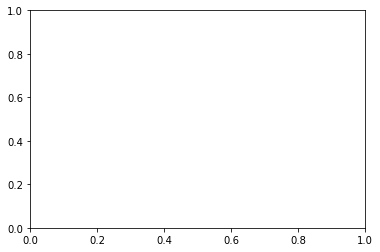

In [17]:
from noise_model import *
from qiskit.circuit import Parameter
from qiskit.ignis.characterization.coherence import t2star_circuits

q = QuantumRegister(1)
c = ClassicalRegister(1)


num_of_gates = (np.linspace(10, 1000, 100)).astype(int)
gate_time = 0.1
qubits = [0]
circuits, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)
time = range(1, 100)

print("Executing the job")
shots = 1024   
emulator = Aer.get_backend('qasm_simulator')
job = execute(circuits, emulator, shots=shots, noise_model=t2_star_noise_model())
result = job.result()

y_data = []
y_error = []
print("Result analysis")
for i in range(len(circuits)):
    data = result.get_counts(i)
    try:
        p0 = data['1']/shots
    except KeyError:
         p0 = 0
    y_data.append(p0)
    y_error.append(np.sqrt(p0*(1-p0)/shots))

plt.errorbar(time, y_data, y_error)
plt.xlabel('Time [micro-seconds = 10*gate_time]')
plt.ylabel('P1(t)')

mod = Model(decay_cosine)

# create parameters, giving initial values
params = mod.make_params(amp=2.0, beta=0.5, omega=5, phi=0)

# you can place bounds on parameters:
params['phi'].max = np.pi/2
params['phi'].min = -np.pi/2
params['amp'].min = 0

# fit data to model
y = mod.fit(y_data, params, t=t)
"""
popt, pcov = curve_fit(T2_func,time , y_data)
curve_expo = [T2_func(i, popt[0], popt[1], popt[2], popt[3], popt[4]) for i in range(len(time))]
plt.plot(time, curve_expo, 'r')
"""
plt.plot(y)

plt.grid(True)
plt.show()


print("T2 = " + str(1/popt[1]))

In [38]:
num_of_gates = (np.linspace(10, 1000, 50)).astype(int)
gate_time = 0.1
qubits = [i for i in range(5)]
t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)
print(t2star_circs[3])

          ┌───┐ ░ ┌────┐ ░ ┌────┐ ░ ┌────┐ ░ ┌────┐ ░ ┌────┐ ░ ┌────┐ ░ ┌────┐»
q45_0: |0>┤ H ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├»
          ├───┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤»
q45_1: |0>┤ H ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├»
          ├───┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤»
q45_2: |0>┤ H ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├»
          ├───┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤»
q45_3: |0>┤ H ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├»
          ├───┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤ ░ ├────┤»
q45_4: |0>┤ H ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├─░─┤ Id ├»
          └───┘ ░ └────┘ ░ └────┘ ░ └────┘ ░ └────┘ ░ └────┘ ░ └────┘ ░ └────┘»
 c45_0: 0 ════════════════════════════════════════════════════════════════════»
                                        

«                                                                          


In [8]:
import numpy as np
from qiskit.ignis.characterization.coherence import t1_circuits

num_of_gates = (np.linspace(10, 1000, 100)).astype(int)
print(num_of_gates)
gate_time = 0.1
qubits = [i for i in range(5)]
t1_circs, t1_xdata = t1_circuits(num_of_gates, gate_time, qubits)
print(t1_xdata)
print(t1_circs[1])

[  10   20   30   40   50   60   70   80   90  100  110  120  130  140
  150  160  170  180  190  200  210  220  230  240  250  260  270  280
  290  300  310  320  330  340  350  360  370  380  390  400  410  420
  430  440  450  460  470  480  490  500  510  520  530  540  550  560
  570  580  590  600  610  620  630  640  650  660  670  680  690  700
  710  720  730  740  750  760  770  780  790  800  810  820  830  840
  850  860  870  880  890  900  910  920  930  940  950  960  970  980
  990 1000]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.